## Introduction

This is an analysis of the Northwind database, a free, open-source database about a fictional company created by Microsoft. I will be using statistical analysis to gather important, relevant information for the company. What follows are my questions asked, hypotheses generated, an analyses conducted for this dataset.

#### Libraries

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import scipy.stats as stats
from statsmodels.stats.multicomp import MultiComparison
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#### Connecting Database

In [2]:
conn = sqlite3.connect('Northwind_small.sqlite')
cur = conn.cursor()

## Question 1

### Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

#### Hypotheses

Null Hypothesis
> **Discounts do not have a statistically significant effect on the quantity of product ordered.**

Alternative Hypothesis
> **Discounts do have a statistically significant effect on the quanity of product ordered.**

I will be using an alpha value of `0.05` for a one-tailed Welch's T-Test.

#### Formatting Data

In [3]:
cur.execute("""SELECT Quantity, Discount 
                FROM OrderDetail;""")
df = pd.DataFrame(cur.fetchall())
df.columns = [x[0] for x in cur.description]
df.head()

,Quantity,Discount
0,12,0.0
1,10,0.0
2,5,0.0
3,9,0.0
4,40,0.0


In [4]:
#check value counts for the discount column
df.Discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

In [5]:
discount = df[df.Discount != 0]
not_discount = df[df.Discount == 0]

print("Discounted Orders: {}".format(len(discount)))
print("Non-discounted Orders: {}".format(len(not_discount)))

Discounted Orders: 838
Non-discounted Orders: 1317


#### Analysis

*Part 1: Does any type of discount affect amount ordered?*

In [6]:
a_mean = discount.Quantity.mean()
b_mean = not_discount.Quantity.mean()

print("Mean Quantity Ordered for Discounted Orders: {}".format(a_mean))
print("Mean Quantity Ordered for Non-discounted Orders: {}".format(b_mean))

Mean Quantity Ordered for Discounted Orders: 27.10978520286396
Mean Quantity Ordered for Non-discounted Orders: 21.715261958997722


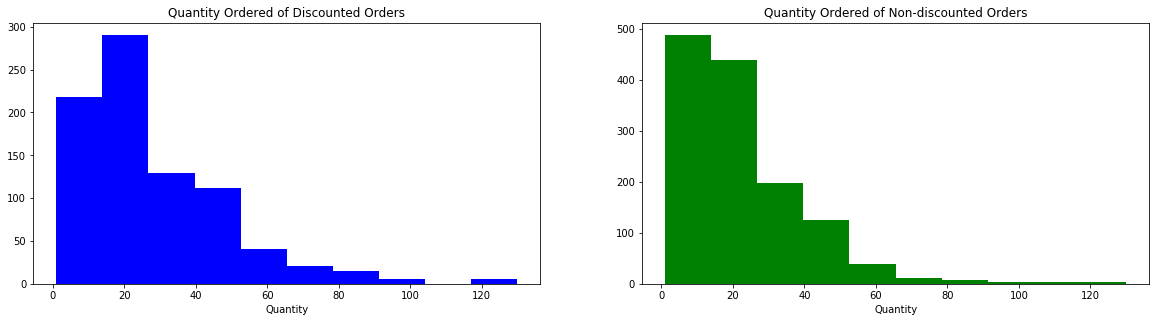

In [7]:
fig_1 = plt.figure(1, figsize=(20, 4.8))

chart_1 = fig_1.add_subplot(121)
chart_2 = fig_1.add_subplot(122)

chart_1.hist(discount.Quantity, color='b')
chart_1.set_xlabel('Quantity')
chart_1.set_title('Quantity Ordered of Discounted Orders')

chart_2.hist(not_discount.Quantity, color='g')
chart_2.set_xlabel('Quantity')
chart_2.set_title('Quantity Ordered of Non-discounted Orders')

plt.show()

Now, in order to test whether or not discounts do in fact have a statistical influence on the amount ordered, we must first determine if the two samples have the same variance. If they do, we can make each sample the same size and use a regular T-Test. If they don't, we can use a Welch's T-Test.

In [8]:
dsct_array = np.array(discount.Quantity)
n_dsct_array = np.array(not_discount.Quantity)

In [9]:
#Levene test to determine equal variance, using alpha = 0.05
def test_variance(data_1, data_2):
    W,p = stats.levene(data_1, data_2)

    if p < 0.05:
        print("The null hypothesis is rejected and the two samples don't have the same variance.")
    else:
        print("The null hypothesis is not rejected and the two samples have the same variance.")

In [10]:
test_variance(dsct_array, n_dsct_array)

The null hypothesis is rejected and the two samples don't have the same variance.


Now, we know we need to use the **Welch's T-Test** to determine statistical significance because we know the following about our two samples:

1. They do not have the same length.
2. They do not have the same variance.
3. And they do not follow normal distribution (as seen in the histograms).

In [11]:
#Welch's T
def welch_t(a, b):
    numerator = a.mean() - b.mean()    
    denominator = np.sqrt(a.var(ddof=1)/a.size + b.var(ddof=1)/b.size)    
    return np.abs(numerator/denominator)

#Welch's Degrees of Freedom
def welch_df(a, b):
    s1 = a.var(ddof=1) 
    s2 = b.var(ddof=1)
    n1 = a.size
    n2 = b.size
    
    numerator = (s1/n1 + s2/n2)**2
    denominator = (s1/ n1)**2/(n1 - 1) + (s2/ n2)**2/(n2 - 1)
    
    return numerator/denominator

In [12]:
t = welch_t(dsct_array, n_dsct_array)
d_free = welch_df(dsct_array, n_dsct_array)
print(t, d_free)

6.239069142123973 1561.7678231942148


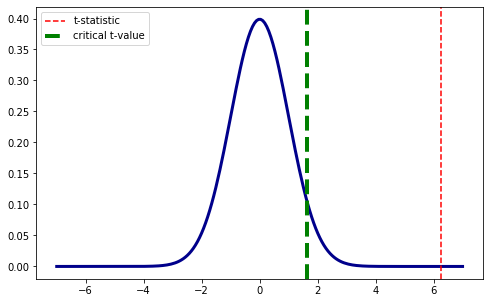

In [13]:
xs = np.linspace(-7, 7, 200)
ys = stats.t.pdf(xs, d_free, 0, 1)
t_crit = np.round(stats.t.ppf(1 - 0.05, df=d_free),3)

fig = plt.figure(figsize=(8,5))
ax = fig.gca()
ax.plot(xs, ys, linewidth=3, color='darkblue')
ax.axvline(t, color='red', linestyle='--',label='t-statistic')
ax.axvline(t_crit,color='green',linestyle='--',lw=4,label='critical t-value')

ax.legend()
plt.show()

In [14]:
#P-Value
p = 1 - stats.t.cdf(t, d_free)
print(p)

2.8282065578366655e-10


In [15]:
def Cohen_d(group1, group2):
    
    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    d = diff / np.sqrt(pooled_var)
    
    return d

In [16]:
d = Cohen_d(dsct_array, n_dsct_array)

print("D-value: {}".format(round(d, 3)))
print("Mean of quantity ordered for discounted items: {}".format(round(dsct_array.mean(),1)))
print("Mean of quantity ordered for non-discounted items: {}".format(round(n_dsct_array.mean(),1)))
print("Mean difference: {}".format(round(dsct_array.mean() - n_dsct_array.mean(),1)))

D-value: 0.286
Mean of quantity ordered for discounted items: 27.1
Mean of quantity ordered for non-discounted items: 21.7
Mean difference: 5.4


Our p-value, `2.82e-10`, is much lower than our alpha `0.05` and thus we can now reject the null hypothesis. Discounts **do** have a statistically significant effect on the quantity of product ordered. This is also visualized by the plotting of our t-statistic, which is much farther to the right on the plot than the critical t-value (the maximum t-value we would expect if the null hypothesis was not rejected).

However, after calculating Cohen's *d* for the discounted and non_discounted orders, we can see that since the calculated `d` is between `0.2` and `0.5`, that the effect of the discount is small. This translates to a 5.4 increase in quantity ordered for discounted items.

___

*Part 2: Now that we know that overall discount does have a statistically significant effect on the quantity of a product in an order, we want to know at what level(s) of discount does this effect the quantity of product in an order?*

In [17]:
#let's look again at the different discounts
df.Discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

Since the discounts of 1%, 2%, 3%, 4%, and 6% all have three or less orders, I'm going to remove them from this part of the analysis and focus only on the following discount groups:

- 5%
- 10%
- 15%
- 20%
- 25%

In [18]:
dsc_5 = np.array(df[df.Discount == 0.05]['Quantity'])
dsc_10 = np.array(df[df.Discount == 0.10]['Quantity'])
dsc_15 = np.array(df[df.Discount == 0.15]['Quantity'])
dsc_20 = np.array(df[df.Discount == 0.20]['Quantity'])
dsc_25 = np.array(df[df.Discount == 0.25]['Quantity'])

all_dscs = list([dsc_5, dsc_10, dsc_15, dsc_20, dsc_25])

In [19]:
#check to make sure df was filtered and formatted properly
for array in all_dscs:
    print("Length: {}, Type: {}".format(len(array), type(array)))

Length: 185, Type: <class 'numpy.ndarray'>
Length: 173, Type: <class 'numpy.ndarray'>
Length: 157, Type: <class 'numpy.ndarray'>
Length: 161, Type: <class 'numpy.ndarray'>
Length: 154, Type: <class 'numpy.ndarray'>


With all arrays ready for each level of discount, we can create a loop that will calculate the t-statistic for each level of discount using the Welch's T-Test.

In [20]:
analysis = []

for array in all_dscs:
    t = welch_t(array, n_dsct_array)
    d_free = welch_df(array, n_dsct_array)
    p = 1 - stats.t.cdf(t, d_free)
    d = Cohen_d(array, n_dsct_array)
    mean = array.mean()
    mean_diff = mean - n_dsct_array.mean()
    
    analysis.append({'Length': len(array), 'T-statistic': t, 'Degrees of Freedom': d_free,
                    'P-Value': p, 'Cohen d': d, 'Mean': mean, 'Mean_diff': mean_diff})

In [21]:
n_df = pd.DataFrame(analysis)
n_df['Discount'] = ['5%', '10%', '15%', '20%', '25%']
n_df['Reject Null?'] = n_df['P-Value'] < 0.05
n_df[['Discount', 'P-Value', 'Reject Null?', 'Cohen d', 'Mean', 'Mean_diff']]

,Discount,P-Value,Reject Null?,Cohen d,Mean,Mean_diff
0,5%,0.000136,True,0.347157,28.010811,6.295549
1,10%,0.018728,True,0.196096,25.236994,3.521732
2,15%,0.000086,True,0.372698,28.382166,6.666904
3,20%,0.000406,True,0.300928,27.024845,5.309583
4,25%,0.000080,True,0.366873,28.240260,6.524998


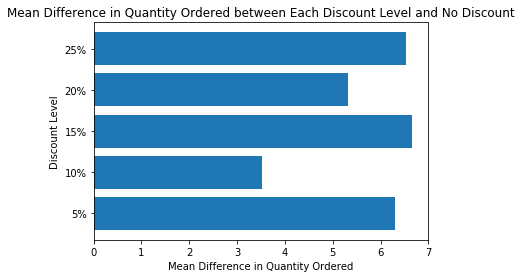

In [22]:
labs = ['5%', '10%', '15%', '20%', '25%']

plt.barh(labs, n_df['Mean_diff'])

plt.title('Mean Difference in Quantity Ordered between Each Discount Level and No Discount')
plt.xlabel('Mean Difference in Quantity Ordered')
plt.ylabel('Discount Level')

plt.show()

#### Conclusion

It looks like for all discount levels (5%, 10%, 15%, 20%, and 25%) we can reject the null hypothesis, since each of their *p-values* are less than the alpha (`0.05`). 

**This means that every discount level has a statistically significant effect on the quantity of product ordered.** 

But, just like we looked at the effect size for the initial part of the question, we need to look at the effect size for each of the discount levels. From our data, we can see that the 10% discount level has the smallest effect, where orders only have on average `3.5` more quantity ordered than non-discounted orders (`d = 0.196`), while the 15% discount level had the largest effect, where orders have on average `6.7` more quanity ordered than non-discounted orders. (`d = 0.373`).

## Question 2

### Do some product categories generate more money per order for Northwind Traders than others?

#### Hypotheses

Null Hypothesis
> **There is no statistical significance between the amount of money each product category generates per order.**

Alternative Hypothesis
> **Some product categories do make significantly more money per order than others.**

I will be using an alpha value of `0.05` in a Tukey's Range test (one-tailed).

#### Formatting Data

In [23]:
cur.execute("""SELECT * 
                FROM OrderDetail o
                JOIN Product p
                ON o.ProductId = p.Id
                JOIN Category c
                ON c.Id = p.CategoryId;""")
df_2 = pd.DataFrame(cur.fetchall())
df_2.columns = [x[0] for x in cur.description]
df_2.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued,Id,CategoryName,Description
0,10248/11,10248,11,14.0,12,0.0,11,Queso Cabrales,5,4,1 kg pkg.,21.00,22,30,30,0,4,Dairy Products,Cheeses
1,10248/42,10248,42,9.8,10,0.0,42,Singaporean Hokkien Fried Mee,20,5,32 - 1 kg pkgs.,14.00,26,0,0,1,5,Grains/Cereals,"Breads, crackers, pasta, and cereal"
2,10248/72,10248,72,34.8,5,0.0,72,Mozzarella di Giovanni,14,4,24 - 200 g pkgs.,34.80,14,0,0,0,4,Dairy Products,Cheeses
3,10249/14,10249,14,18.6,9,0.0,14,Tofu,6,7,40 - 100 g pkgs.,23.25,35,0,0,0,7,Produce,Dried fruit and bean curd
4,10249/51,10249,51,42.4,40,0.0,51,Manjimup Dried Apples,24,7,50 - 300 g pkgs.,53.00,20,0,10,0,7,Produce,Dried fruit and bean curd


In [24]:
keep_cols = ['ProductName', 'CategoryName', 'UnitPrice', 'Quantity', 'Discount', 
            'Discontinued']
df_2 = df_2[keep_cols]
df_2.head()

,ProductName,CategoryName,UnitPrice,UnitPrice,Quantity,Discount,Discontinued
0,Queso Cabrales,Dairy Products,14.0,21.00,12,0.0,0
1,Singaporean Hokkien Fried Mee,Grains/Cereals,9.8,14.00,10,0.0,1
2,Mozzarella di Giovanni,Dairy Products,34.8,34.80,5,0.0,0
3,Tofu,Produce,18.6,23.25,9,0.0,0
4,Manjimup Dried Apples,Produce,42.4,53.00,40,0.0,0


In [25]:
df_2 = (df_2[df_2.Discontinued == 0]
       .reset_index()
       .iloc[:,[1,2,3,5,6]])
df_2['OrderCost'] = df_2.UnitPrice*df_2.Quantity*(1-df_2.Discount)

In [26]:
cost_by_cat = df_2[['CategoryName', 'OrderCost']]

#### Analysis

In [27]:
print("Number of Categories: {}".format(len(cost_by_cat.CategoryName.unique())))
print("Categories: {}".format(", ".join(cost_by_cat.CategoryName.unique())))

Number of Categories: 8
Categories: Dairy Products, Produce, Seafood, Condiments, Grains/Cereals, Confections, Beverages, Meat/Poultry


Let's first look at the distribution of total order cost for each of the categories.

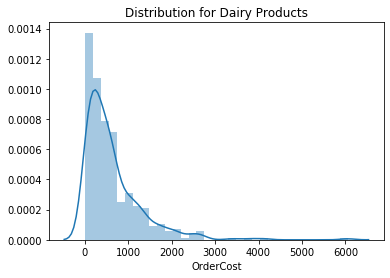

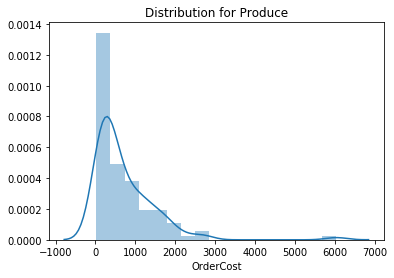

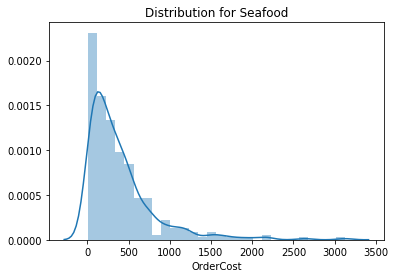

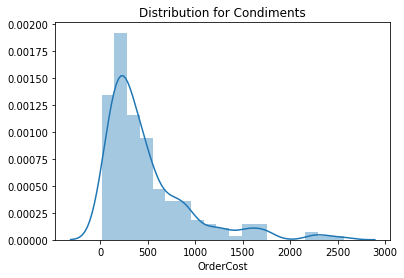

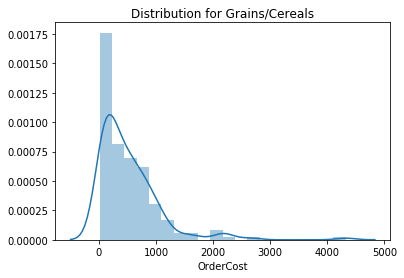

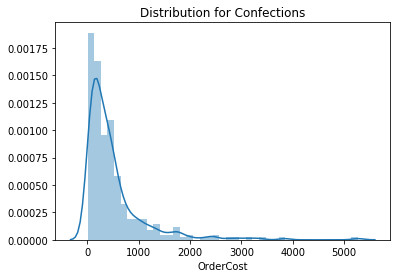

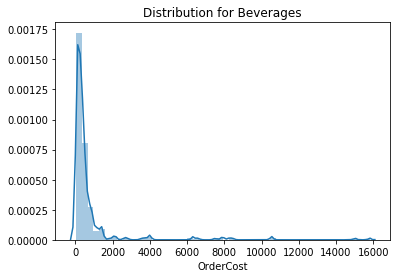

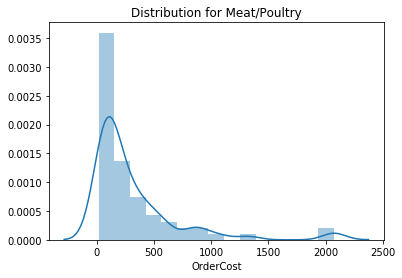

In [28]:
categories = list(cost_by_cat.CategoryName.unique())

for cat in categories:
    sns.distplot(cost_by_cat[cost_by_cat.CategoryName == cat]['OrderCost'])
    plt.title('Distribution for {}'.format(cat))
    plt.show()

Looking through our categories, quite a few of them have some very large order costs. To account for these outliers, I'm going to remove all orders that are above \$2,000.

In [29]:
clean_cat = cost_by_cat[cost_by_cat.OrderCost <= 2000]

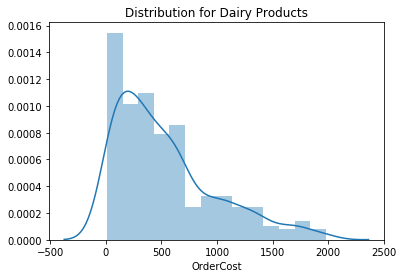

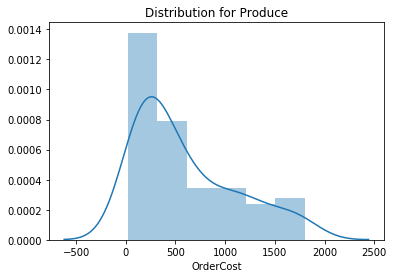

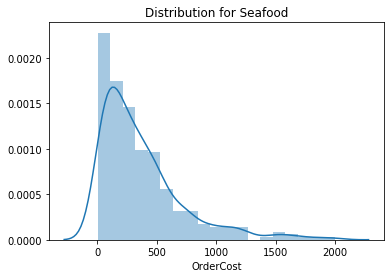

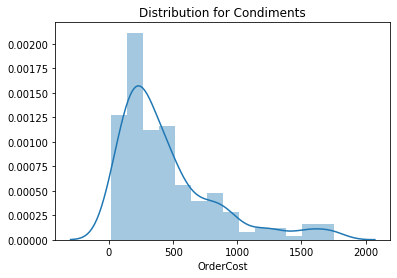

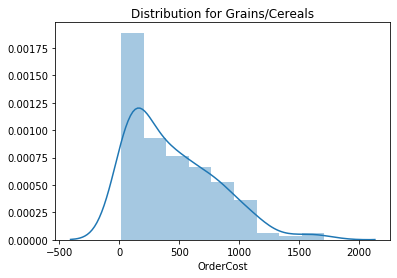

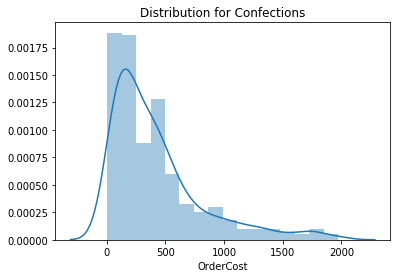

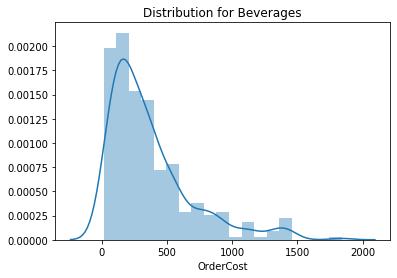

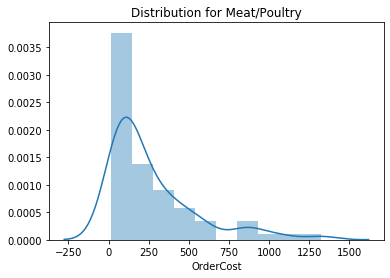

In [30]:
for cat in categories:
    sns.distplot(clean_cat[clean_cat.CategoryName == cat]['OrderCost'])
    plt.title('Distribution for {}'.format(cat))
    plt.show()

Having removed most of the large outliers, the distributions look better. They aren't "perfect" normal distributions, but they look better than the last round of histograms.

I'm now going to try using a Tukey's range test to determine whether or not the average order cost from each category is statistically significant than the other categories. The Tukey's range test provides an easy way to perform multiple comparisons.

In [31]:
#Tukey's range test
compare = MultiComparison(clean_cat['OrderCost'], clean_cat['CategoryName'])
result = compare.tukeyhsd()
print(result)

           Multiple Comparison of Means - Tukey HSD, FWER=0.05           
    group1         group2      meandiff p-adj    lower     upper   reject
-------------------------------------------------------------------------
     Beverages     Condiments   85.4183 0.2116  -19.7606  190.5973  False
     Beverages    Confections   55.1766 0.5923  -36.8872  147.2405  False
     Beverages Dairy Products   167.833  0.001   77.4509  258.2152   True
     Beverages Grains/Cereals   80.3459 0.3853  -33.0825  193.7742  False
     Beverages   Meat/Poultry  -97.4307 0.5596 -255.2445   60.3831  False
     Beverages        Produce  231.8989  0.001   96.4248  367.3731   True
     Beverages        Seafood    5.4633    0.9  -86.4577   97.3843  False
    Condiments    Confections  -30.2417    0.9 -135.8503    75.367  False
    Condiments Dairy Products   82.4147  0.241  -21.7312  186.5606  False
    Condiments Grains/Cereals   -5.0725    0.9 -129.7458  119.6008  False
    Condiments   Meat/Poultry  -182.84

Using this multiple comparison of means, we can determine which of the product categories generate a significantly larger amount of money per order than the other product categories. By reading the table above, any pairing that can reject the null hypothesis (meaning there is a "True" in the *reject* column), then the two categories are significantly different.

Listed below is each category and the categories that are significantly different from it:

**Beverage**
- Dairy Products
- Produce

**Condiments**
- Meat/Poultry
- Produce

**Confections**
- Dairy Products
- Produce

**Dairy Products**
- Beverage
- Confections
- Meat/Poultry
- Seafood

**Grains/Cereals**
- Meat/Poultry
- Produce
- Seafood

**Meat/Poultry**
- Condiments
- Dairy Products
- Grains/Cereals
- Produce

**Produce**
- Beverage
- Condiments
- Confections
- Grains/Cereals
- Meat/Poultry
- Seafood

**Seafood**
- Dairy Products
- Produce

Using a built-in method for the Tukey test, we can visualize how these groups relate to each other.

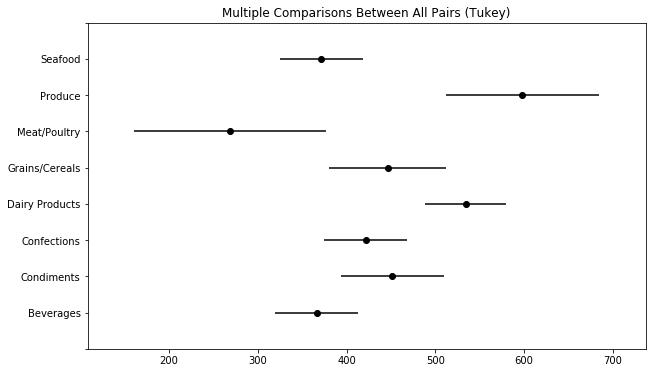

In [32]:
result.plot_simultaneous()
plt.show()

From both the table and the visual representation, we can start to loosely group the different categories into some kind of order.

1. Group 1 (Categories with highest average order value):
    - Produce
    - Dairy Products


2. Group 2
    - Grains/Cereals
    - Confections
    - Condiments 


3. Group 3 (Categories with lowest average order value):
    - Seafood
    - Beverages
    - Meat/Poultry

I want to next look at the Cohen's d-value between all these different product categories, to see if I might be able to better order them by using their effect sizes.

In [33]:
prod = np.array(clean_cat[clean_cat.CategoryName == 'Produce']['OrderCost'])
dairy = np.array(clean_cat[clean_cat.CategoryName == 'Dairy Products']['OrderCost'])
grains = np.array(clean_cat[clean_cat.CategoryName == 'Grains/Cereals']['OrderCost'])
confect = np.array(clean_cat[clean_cat.CategoryName == 'Confections']['OrderCost'])
cond = np.array(clean_cat[clean_cat.CategoryName == 'Condiments']['OrderCost'])
sea = np.array(clean_cat[clean_cat.CategoryName == 'Seafood']['OrderCost'])
bev = np.array(clean_cat[clean_cat.CategoryName == 'Beverages']['OrderCost'])
meat = np.array(clean_cat[clean_cat.CategoryName == 'Meat/Poultry']['OrderCost'])

cats = [prod, dairy, grains, confect, cond, sea, bev, meat]

In [34]:
names = ['prod', 'dairy', 'grains', 'confect', 'cond', 'sea', 'bev', 'meat']
all_ds = []

In [35]:
#a function that will be used to create a Dataframe showing all the different d values
def d_cat(cat, lists):
    temp = []
    for list_ in lists:
        d = Cohen_d(cat, list_)
        temp.append(round(d, 3))
    
    return temp

In [36]:
d_values = []

for cat in cats:
    d_values.append(d_cat(cat, cats))

In [37]:
all_ds = pd.DataFrame(d_values, columns=names, index=names)
all_ds

,prod,dairy,grains,confect,cond,sea,bev,meat
prod,0.000,0.137,0.359,0.417,0.343,0.575,0.628,0.772
dairy,-0.137,0.000,0.204,0.263,0.191,0.397,0.426,0.615
grains,-0.359,-0.204,0.000,0.065,-0.013,0.210,0.241,0.522
confect,-0.417,-0.263,-0.065,0.000,-0.077,0.132,0.154,0.403
cond,-0.343,-0.191,0.013,0.077,0.000,0.218,0.247,0.506
sea,-0.575,-0.397,-0.210,-0.132,-0.218,0.000,0.016,0.301
bev,-0.628,-0.426,-0.241,-0.154,-0.247,-0.016,0.000,0.312
meat,-0.772,-0.615,-0.522,-0.403,-0.506,-0.301,-0.312,0.000


#### Conclusion

By basing our order off of the Cohen's d-value between the 'Produce' category and every other category, we get the following hierarchy:

1) **Produce** (Highest Average Cost per Order)

2) **Dairy Products**

3) **Condiments**

4) **Grains/Cereals**

5) **Confections**

6) **Seafood**

7) **Beverages**

8) **Meat/Poultry** (Lowest Average Cost per Order)

However, it should be remembered that most of the categories in the middle are not statistically different from each other, like 'Grains/Cereals', 'Confections', and 'Condiments'.

The reason this question is important is because it is one of many metrics that can be used to determine which parts of the company are more profitable than others. It can also be used in tandem with some basic calculations to identify areas where the company should invest more time to generate more income.

In this example, the **Produce** category of products sold by Northwind Traders makes statistically more money per order than every other category but **Dairy Products**, but it has the second fewest number of orders.

In [38]:
(clean_cat
 .groupby(by = 'CategoryName')
 .agg(['mean', 'count'])
 .sort_values(('OrderCost', 'count'), ascending=False))

OrderCost      
                      mean count
CategoryName                    
Dairy Products  534.031476   349
Beverages       366.198429   331
Seafood         371.661771   326
Confections     421.375077   324
Condiments      451.616757   202
Grains/Cereals  446.544297   160
Produce         598.097347    98
Meat/Poultry    268.767724    67

If I were at Northwind, I would start having my employees try to sell more **Produce**, since there is a lot of potential for growth and increased income.

## Question 3

### Do employees in certain regions generate more money for the company than other employees in other regions?

#### Hypotheses

Null Hypothesis
> **There is no statistical significance between the amounts generated by employees in each region.**

Alternative Hypothesis
> **Employees in some regions generate significantly more money than employees in other regions.**

I will be using an alpha value of `0.025` in a two-tailed Student's T-Test.

#### Formatting Data

In [39]:
cur.execute("""SELECT o.Id, e.Region, od.UnitPrice, od.Quantity, od.Discount, e.Id as EmployeeID
                FROM Employee e
                JOIN 'Order' o
                ON e.Id = o.EmployeeId
                JOIN OrderDetail od
                ON o.Id = od.OrderId;""")
df_3 = pd.DataFrame(cur.fetchall())
df_3.columns = [x[0] for x in cur.description]
df_3.head()

,Id,Region,UnitPrice,Quantity,Discount,EmployeeID
0,10248,British Isles,14.0,12,0.0,5
1,10248,British Isles,9.8,10,0.0,5
2,10248,British Isles,34.8,5,0.0,5
3,10249,British Isles,18.6,9,0.0,6
4,10249,British Isles,42.4,40,0.0,6


In [40]:
df_3['OrderCost'] = df_3.UnitPrice*df_3.Quantity*(1-df_3.Discount)
keep = ['Id', 'Region', 'OrderCost', 'EmployeeID']
df_3_2 = df_3[keep]
region = df_3_2.groupby(by=['Region','Id', 'EmployeeID'], as_index=False).sum()
region.head()

,Region,Id,EmployeeID,OrderCost
0,British Isles,10248,5,440.00
1,British Isles,10249,6,1863.40
2,British Isles,10254,5,556.62
3,British Isles,10255,9,2490.50
4,British Isles,10263,9,1873.80


In [41]:
print("Number of sales made in North America: {}"
      .format(len(region[region.Region == "North America"])))
print("Number of sales made in British Isles: {}"
      .format(len(region[region.Region == "British Isles"])))

Number of sales made in North America: 606
Number of sales made in British Isles: 224


In [42]:
keep = ['Region', 'OrderCost']
region_df = region[keep]
region_df.head()

,Region,OrderCost
0,British Isles,440.00
1,British Isles,1863.40
2,British Isles,556.62
3,British Isles,2490.50
4,British Isles,1873.80


#### Analysis

Lets check our two separate samples for normality.

In [43]:
na_sales = region_df[region_df.Region == 'North America']
bi_sales = region_df[region_df.Region == 'British Isles']

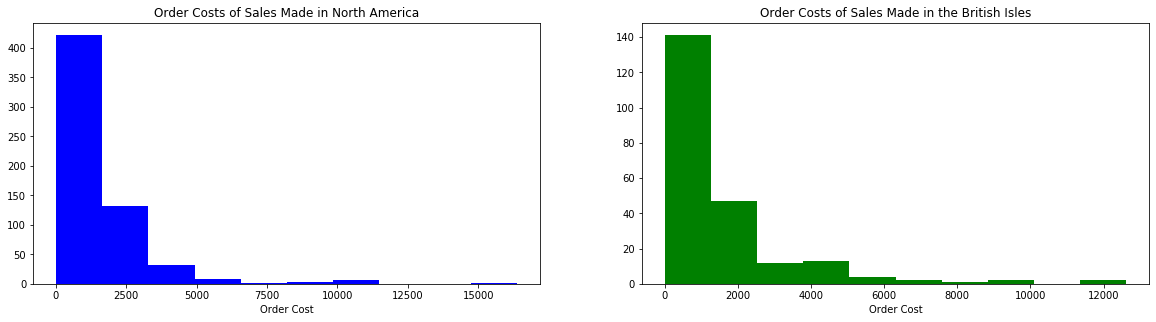

In [44]:
fig_2 = plt.figure(1, figsize=(20, 4.8))

chart_3 = fig_2.add_subplot(121)
chart_4 = fig_2.add_subplot(122)

chart_3.hist(na_sales.OrderCost, color='b')
chart_3.set_xlabel('Order Cost')
chart_3.set_title('Order Costs of Sales Made in North America')

chart_4.hist(bi_sales.OrderCost, color='g')
chart_4.set_xlabel('Order Cost')
chart_4.set_title('Order Costs of Sales Made in the British Isles')

plt.show()

By looking at our histograms, we can see that both regions have some outlying order costs. Just like we did with the previous questions, let's remove some of those outliers and see how that helps.

In [45]:
new_na_sales = na_sales[na_sales.OrderCost <= 5000]
new_bi_sales = bi_sales[bi_sales.OrderCost <= 5000]

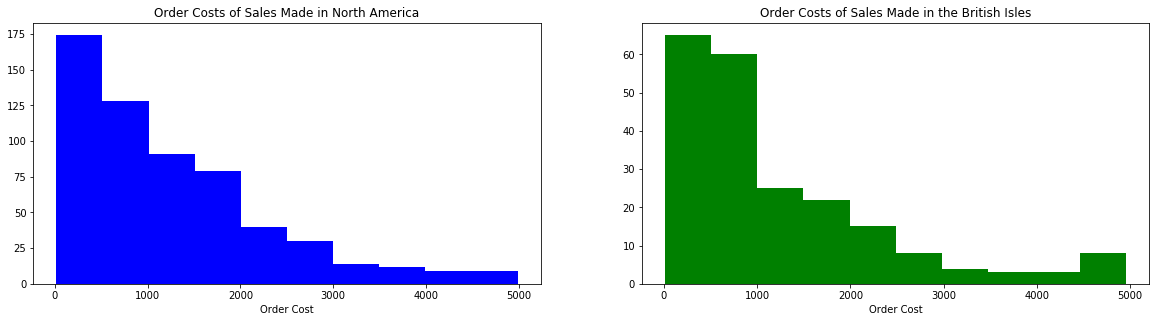

In [46]:
fig_2 = plt.figure(1, figsize=(20, 4.8))

chart_3 = fig_2.add_subplot(121)
chart_4 = fig_2.add_subplot(122)

chart_3.hist(new_na_sales.OrderCost, color='b')
chart_3.set_xlabel('Order Cost')
chart_3.set_title('Order Costs of Sales Made in North America')

chart_4.hist(new_bi_sales.OrderCost, color='g')
chart_4.set_xlabel('Order Cost')
chart_4.set_title('Order Costs of Sales Made in the British Isles')

plt.show()

Well, our plots are still positively skewed, but at least they look better than before we removed orders over \$2,000.

Let's first check to see if our two independent samples have the same variance. If they do, we'll be able to use a regular two-tailed **Student's T-Test**. If their variances are no the same, then we'll need to use a **Welch's T-Test**.

In [47]:
#two different groups for analysis
na = np.array(new_na_sales.OrderCost)
bi = np.array(new_bi_sales.OrderCost)

In [48]:
test_variance(na, bi)

The null hypothesis is not rejected and the two samples have the same variance.


In [49]:
#Since the variance is the same for each group, we can just use a Student's t-test
t,p = stats.ttest_ind(na,bi)
print("T: {}".format(t))
print("p-value: {}".format(p))

T: 0.5386950670719326
p-value: 0.5902477020901038


In [50]:
d = Cohen_d(na, bi)

print(round(d, 3))

0.043


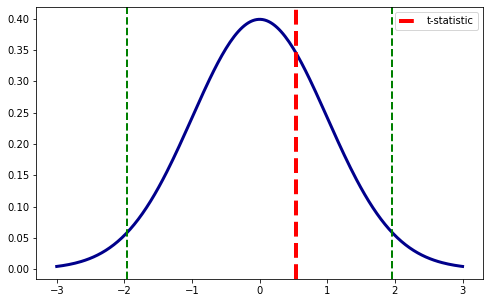

In [51]:
xs = np.linspace(-3, 3, 200)
ys = stats.t.pdf(xs, (len(na)+len(bi)-2), 0, 1)
t_crit = stats.t.ppf(1-0.025, (len(na)+len(bi)-2))

fig = plt.figure(figsize=(8,5))
ax = fig.gca()
ax.plot(xs, ys, linewidth=3, color='darkblue')
ax.axvline(t, color='red', linestyle='--', lw=4, label='t-statistic')
ax.axvline(t_crit,color='green',linestyle='--',lw=2)
ax.axvline(-t_crit,color='green',linestyle='--',lw=2)

ax.legend()
plt.show()

In [52]:
check = region[region.OrderCost <= 5000]

print("Number of North American Employees: {}".format(len(region[region.Region =='North America']['EmployeeID'].unique())))
print("Number of British Isles Employees: {}".format(len(region[region.Region =='British Isles']['EmployeeID'].unique())))
print('\n')
print("Number of North American Sales: {}".format(len(new_na_sales)))
print("Number of British Isles Sales: {}".format(len(new_bi_sales)))

Number of North American Employees: 5
Number of British Isles Employees: 4


Number of North American Sales: 586
Number of British Isles Sales: 213


#### Conclusion

We can see that revenue generated per order by the two regions reponsible for selling Northwind's products, **North America** and the **British Isles**, is not statistically different, therefore we must accept the null hypothesis. In the graph above, we can see that our t-statistic is between the positive and negative t-critical values, meaning that the one group doesn't sell statistically more or less than the other per order.

Using a two-tailed Student's T-Test, our resulting *p-value* was `0.59`, which is greater than our stated *alpha* value of `0.025`.

However, there is still some useful information that has come out of this test. We've established that each region generates the same amount of money per order, and after a quick look at the data, we can also see that each region has roughly the same number of employees (`5` in **North America** and `4` in the **British Isles**). Now, if we look at the number of sales made in each region, we can see that the number of sales coming out of **North America** (`586`) is over twice the number of sales coming out of the **British Isles** (`213`).

So though each region generates the same amount of money per order, we can see that the **North American** employees make more money for the company than their **British Isles** counterparts. I suggest Northwind look into incentive or training programs for their employees in the British Isles to help increase the number of sales they make.

## Question 4

### Are there customer regions that purchase significantly more goods from Northwind Traders than others?

#### Hypotheses

Null Hypothesis
> **There is no statistical significance between the amount purchased by each region?**

Alternative Hypothesis
> **Customers in some regions do purchase significantly more than customers in other regions.**

I will be using an alpha value of `0.05` in a Tukey's Range test (one-tailed).

In the previous question we looked to see if the employees in North America made more money per order than employees in the British Isles (or vice versa). We concluded that there was no statistical significance.

Now we want to see if customers in different regions purchase more from Northwind Traders than customers in other regions.

#### Formatting Data

In [53]:
cur.execute("""SELECT c.Region, o.Id, od.UnitPrice, od.Quantity, od.Discount
                FROM Customer c
                JOIN 'Order' o
                ON c.ID = o.CustomerId
                JOIN OrderDetail od
                on o.Id = od.OrderId;""")
df_4 = pd.DataFrame(cur.fetchall())
df_4.columns = [x[0] for x in cur.description]
df_4.head()

,Region,Id,UnitPrice,Quantity,Discount
0,Western Europe,10248,14.0,12,0.0
1,Western Europe,10248,9.8,10,0.0
2,Western Europe,10248,34.8,5,0.0
3,Western Europe,10249,18.6,9,0.0
4,Western Europe,10249,42.4,40,0.0


In [54]:
df_4['OrderCost'] = df_4.UnitPrice*df_4.Quantity*(1-df_4.Discount)
purchase_df = df_4.groupby(by=['Region','Id'], as_index=False).sum()
purchase_df.head()

,Region,Id,UnitPrice,Quantity,Discount,OrderCost
0,British Isles,10289,34.6,39,0.0,479.4
1,British Isles,10298,113.8,125,0.5,2645.0
2,British Isles,10309,102.8,75,0.0,1762.0
3,British Isles,10315,23.2,44,0.0,516.8
4,British Isles,10318,22.1,26,0.0,240.4


In [55]:
keep = ['Region', 'OrderCost']
purchase_df2 = purchase_df[keep]
regions_list = list(purchase_df2.Region.unique())

print("Number of regions: {}".format(len(regions_list)))
print("Regions: {}"
      .format(', '.join(regions_list)))

Number of regions: 9
Regions: British Isles, Central America, Eastern Europe, North America, Northern Europe, Scandinavia, South America, Southern Europe, Western Europe


#### Analysis

Let's start by looking at the distributions of order costs for each region.

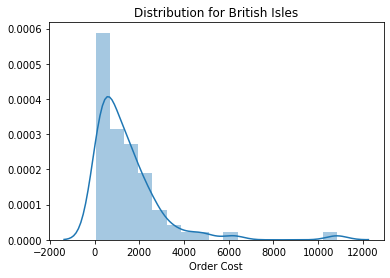

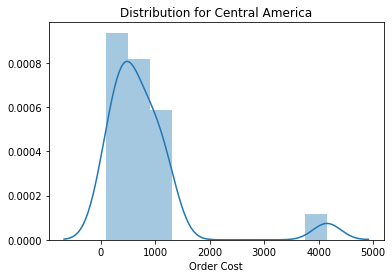

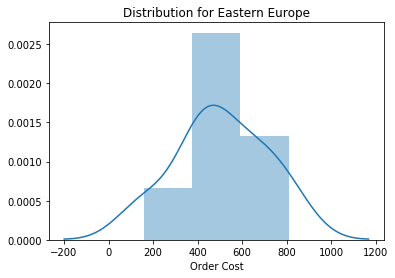

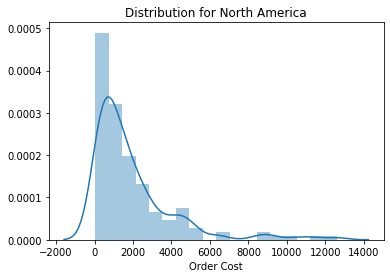

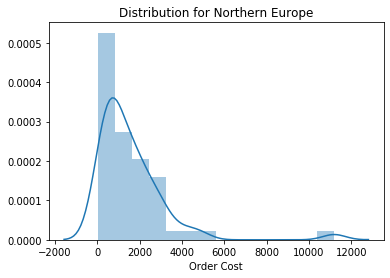

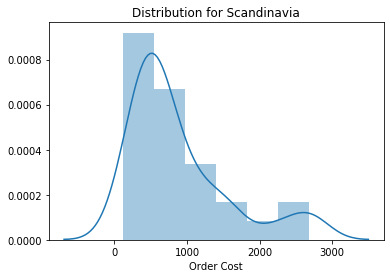

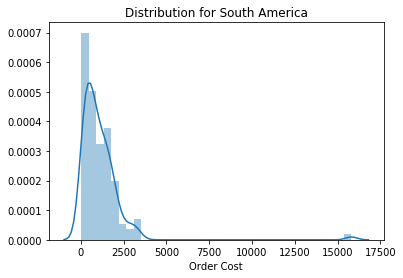

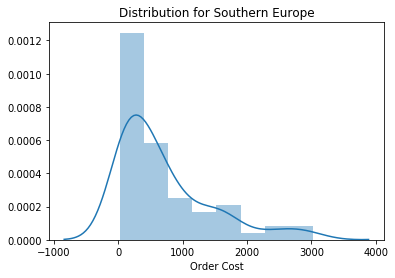

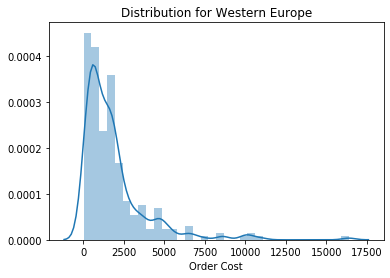

In [56]:
for region in regions_list:
    sns.distplot(purchase_df2[purchase_df2.Region == region]['OrderCost'])
    plt.title('Distribution for {}'.format(region))
    plt.xlabel('Order Cost')
    plt.show()

In [57]:
(purchase_df2
 .groupby(by = 'Region')
 .agg(['mean', 'count'])
 .sort_values(('OrderCost', 'count'), ascending=False))

OrderCost      
                        mean count
Region                            
Western Europe   1851.280914   272
North America    1945.926977   152
South America    1123.447307   127
British Isles    1452.682867    75
Southern Europe   706.651836    64
Northern Europe  1584.657500    55
Scandinavia       876.614375    28
Central America   788.480952    21
Eastern Europe    504.564286     7

There are some regions with pretty large outliers, so we'll need to adjust our samples by removing them. Also, after a quick glance at the number of orders from customers in each region, we should probably remove **Scandinavia**, **Central America**, and **Eastern Europe** from our analysis since the number of orders are below 30.

In [58]:
reg_rmv = ['Scandinavia', 'Central America', 'Eastern Europe']

purchase_df3 = purchase_df2[(purchase_df2.OrderCost <= 6000) &
                           (~purchase_df2.Region.isin(reg_rmv))]

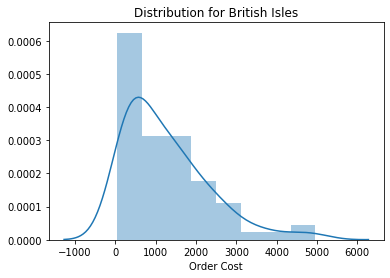

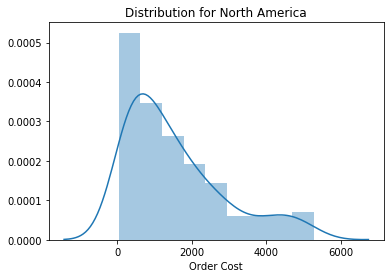

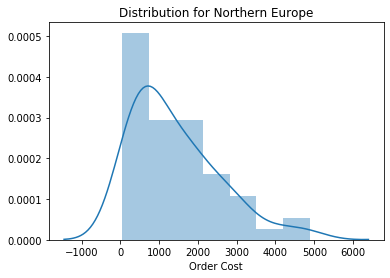

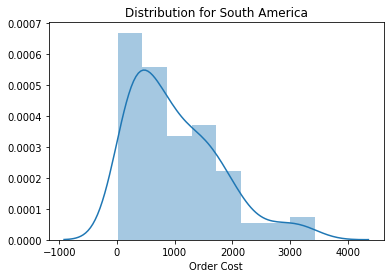

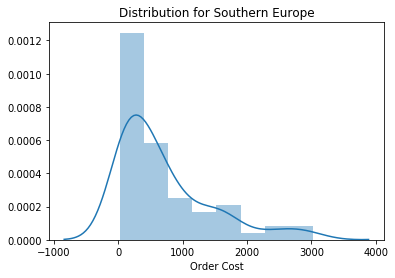

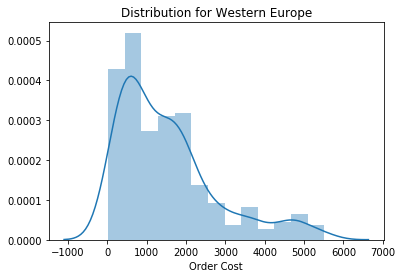

In [59]:
new_regions = list(purchase_df3.Region.unique())

for region in new_regions:
    sns.distplot(purchase_df3[purchase_df3.Region == region]['OrderCost'])
    plt.title('Distribution for {}'.format(region))
    plt.xlabel('Order Cost')
    plt.show()

Now with our outliers removed, we can try to determine the relationship between these regions using another Tukey's Range Test.

In [60]:
#Tukey's range test
compare_2 = MultiComparison(purchase_df3['OrderCost'], purchase_df3['Region'])
result_2 = compare_2.tukeyhsd()
print(result_2)

            Multiple Comparison of Means - Tukey HSD, FWER=0.05             
     group1          group2      meandiff p-adj    lower      upper   reject
----------------------------------------------------------------------------
  British Isles   North America  281.8314 0.5105  -183.8088  747.4716  False
  British Isles Northern Europe   147.695    0.9  -434.0154  729.4054  False
  British Isles   South America  -252.228 0.6359  -728.9258  224.4698  False
  British Isles Southern Europe -552.4636 0.0518  -1107.437    2.5098  False
  British Isles  Western Europe  261.0862 0.5057  -168.1905  690.3629  False
  North America Northern Europe -134.1364    0.9  -651.2879  383.0151  False
  North America   South America -534.0594 0.0017  -929.4066 -138.7122   True
  North America Southern Europe  -834.295  0.001  -1321.177 -347.4129   True
  North America  Western Europe  -20.7452    0.9   -357.401  315.9106  False
Northern Europe   South America -399.9231 0.2541  -927.0527  127.2066  False

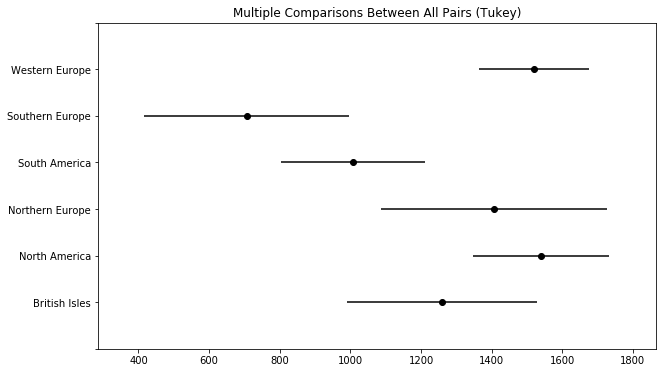

In [61]:
result_2.plot_simultaneous()
plt.show()

Using both the table and visualization of the results of the Tukey's range test, we can see that **yes, some regions do purchase more from Northwind Traders than others, though there is no clear heirarchy**.

For example, **North America** purchases on average `$534` more product per order than **South America**, and `$834` more per order than **Southern Europe**. However, there is no statistical significance between the amount per purchase in **North America** compared to the amount purchased in **Northern Europe**, **Western Europe**, and the **British Isles**.

In [62]:
#setting up arrays for determing effect sizes
we = np.array(purchase_df3[purchase_df3.Region == 'Western Europe']['OrderCost'])
se = np.array(purchase_df3[purchase_df3.Region == 'Southern Europe']['OrderCost'])
sa = np.array(purchase_df3[purchase_df3.Region == 'South America']['OrderCost'])
ne = np.array(purchase_df3[purchase_df3.Region == 'Northern Europe']['OrderCost'])
na = np.array(purchase_df3[purchase_df3.Region == 'North America']['OrderCost'])
bi = np.array(purchase_df3[purchase_df3.Region == 'British Isles']['OrderCost'])

regs = [we, se, sa, ne, na, bi]

In [63]:
names = ['West Eu.', 'South Eu.', 'South Am.', 'North Eu.', 'North Am.', 'British Is.']
all_ds = []

In [64]:
d_values = []

for reg in regs:
    d_values.append(d_cat(reg, regs))

In [65]:
all_ds = pd.DataFrame(d_values, columns=names, index=names)
all_ds

,West Eu.,South Eu.,South Am.,North Eu.,North Am.,British Is.
West Eu.,0.000,0.696,0.459,0.092,-0.016,0.215
South Eu.,-0.696,0.000,-0.399,-0.752,-0.709,-0.605
South Am.,-0.459,0.399,0.000,-0.449,-0.484,-0.286
North Eu.,-0.092,0.752,0.449,0.000,-0.105,0.136
North Am.,0.016,0.709,0.484,0.105,0.000,0.227
British Is.,-0.215,0.605,0.286,-0.136,-0.227,0.000


In [66]:
bar = (purchase_df3
 .groupby(by = 'Region', as_index=False)
 .mean())

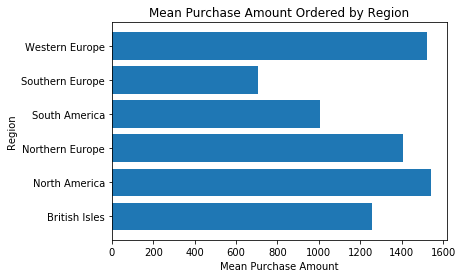

In [67]:
labs = ['British Isles', 'North America', 'Northern Europe', 'South America',
        'Southern Europe', 'Western Europe']

plt.barh(labs, bar['OrderCost'])

plt.title('Mean Purchase Amount Ordered by Region')
plt.xlabel('Mean Purchase Amount')
plt.ylabel('Region')

plt.show()

In [68]:
(purchase_df3
 .groupby(by = 'Region')
 .agg(['mean', 'count'])
 .sort_values(('OrderCost', 'count'), ascending=False))

OrderCost      
                        mean count
Region                            
Western Europe   1520.201610   260
North America    1540.946809   144
South America    1006.887365   126
British Isles    1259.115411    73
Southern Europe   706.651836    64
Northern Europe  1406.810417    54

#### Conclusion

We can reject the null hypothesis, since we've been able to show that there are in fact statistically significant differences between the amount each region purchases. What we can't do with our data is determine an order for which region purchases the most all the way down to which one purchases the least. The largest difference we discovered was between **North America** (with an average OrderCost of `$1,540`) and **Southern Europe** (`$707`). The Cohen's d-value between these two was `0.752`, meaning there is a medium effect size between the two groups.

But this information is still useful. Looking again at the number of purchases per customer region, we can see that **Southern Europe**, which has the lowest mean OrderCost, and statistically speaking is in the bottom tier of customer regions, also has the second lowest number of purchases. Northwind could use this analysis to justify an increase in advertisements in that region of the world to try and get more customers.

## Final Conclusion

This project set out to answer questions about the Northwind Traders dataset using statistical testing. Below are the summarized findings of this analysis.

#### Summary of Findings

1) Discounts have a statistically significant effect on the amount of product ordered, in that discounted orders order a higher quantity of product. This is true for all discount levels (5%, 10%, 15%, 20%, and 25%).

2) There are some product categories that generate more money per order than others. The main takeaways from this is that the **Produce** categorey has the highest average cost/order, while the **Meat/Poultry** has the lowest average cost/order. Most of the other categories in the middle are not statistically different from each other. It should also be noted that even though **Produce** has the highest cost/order, it has the second lowest number of orders, and it would be in Northwind's best interest to have their employees try to sell more **Produce**.

3) There are two regions in the world where Northwind's employees are based out of, **North America** and the **British Isles**. It was determined that there was not a statistically significant difference between the average revenue generated per order between the two regions.

4) Finally, it was determined that yes, there are in fact some statistically significant differences between different regions regarding the amount purchased per order, but there wasn't enough of a difference between all of the regions to determine a hierarchy.

#### Potential Follow-Up Questions

This was just a brief analysis of the Northwind dataset, and there are many more questions that could be asked and answered, including follow-ups to questions I've already asked, like:

    1) It's been determined that discounts result in a higher quantity ordered, but do they actually result in more revenue for the company?
    
    2) Even though there is no difference between the amount sold by each region, is there a difference between the amount by the various employees? Are some employees better at selling goods than others?
    
    3) Is there a statically significant difference in the amount ordered for each product category by region? That is, do some regions order more of one category of product than other regions? Or even, do some regions order more of one category of product compared to other product categories?